In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


# Limpeza dos Dados

In [2]:
sales = pd.read_csv('sales.csv')

# # Ajusta o formato da data
# sales['Date'] = pd.to_datetime(sales['Date'], format='%d-%m-%Y')
# sales.set_index('Date', inplace=True)

sales.loc[sales['Fuel_Price'] > 10, 'Fuel_Price'] = sales['Fuel_Price'] / 1000
sales['Unemployment'] = sales['Unemployment'] / 1000

sales.head(10)

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


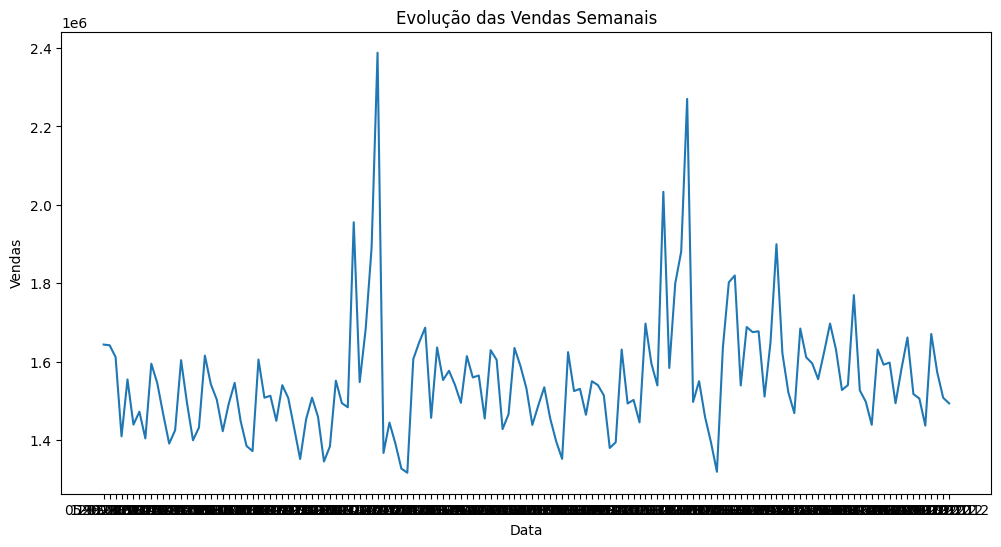

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(sales['Date'], sales['Weekly_Sales'])
plt.title('Evolução das Vendas Semanais')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.show()

# Análise Exploratória

## Primeiras Impressões

Faz-se uma série de visualizações com o objetivo de facilitar a compreenção dos dados que temos. O objetivo é entender de quais informações tem-se de partida.

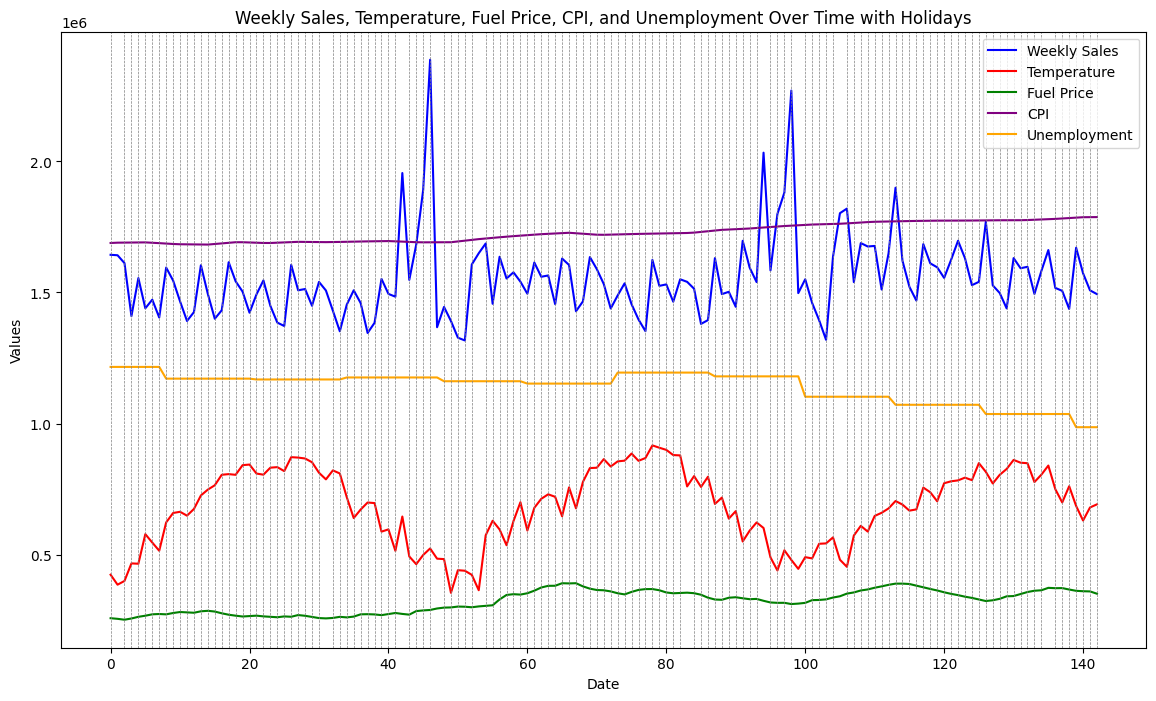

In [4]:
# Multiplicadores para ajustar a escala dos valores
multipliers = {
    'Weekly_Sales': 1,
    'Temperature': 10000,
    'Fuel_Price': 100000,
    'CPI': 8000,
    'Unemployment': 150000
}

plt.figure(figsize=(14, 8))

plt.plot(sales.index, sales['Weekly_Sales'] * multipliers['Weekly_Sales'], label='Weekly Sales', color='blue')
plt.plot(sales.index, sales['Temperature'] * multipliers['Temperature'], label='Temperature', color='red')
plt.plot(sales.index, sales['Fuel_Price'] * multipliers['Fuel_Price'], label='Fuel Price', color='green')
plt.plot(sales.index, sales['CPI'] * multipliers['CPI'], label='CPI', color='purple')
plt.plot(sales.index, sales['Unemployment'] * multipliers['Unemployment'], label='Unemployment', color='orange')

for date, flag in zip(sales.index, sales['Holiday_Flag']):
    if flag == 0:
        plt.axvline(x=date, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Weekly Sales, Temperature, Fuel Price, CPI, and Unemployment Over Time with Holidays')
plt.legend()

plt.show()

### Observações

A primeira coisa a ser notada é que a presença ou ausência de feriados na semana não é uma informação relevante por si só, uma vez que tanto grandes picos quanto vales de venda, bem como valores intermediários, se encontram associados a estas semanas. Gera-se novo gráfico sem esta informação para uma visualização mais limpa.

A segunda informação mais notável é uma possível correlação entre a queda de temperatura e uma forte oscilação positiva nas vendas. Porém, ao olhar mais atentamente, justamente quando as temperaturas mantêm-se ainda mais baixas, antes de subirem novamente, as vendas despencam. Observa-se portanto que, na verdade, a queda da temperatura está correlacionada ao final do ano, e as festas de fim de ano, por sua vez, são o fenômeno por trás da alavancagem sazonal das vendas, que despencam em janeiro.

## Análise da Média Móvel

Nota-se que as demais colunas, candidatas a análises de correlação mais estritas, apresentam muito menos oscilações ao longo do calendário que as Vendas Semanais, faz-se útil extrair valores de média móvel desta para efeitos comparativos. 

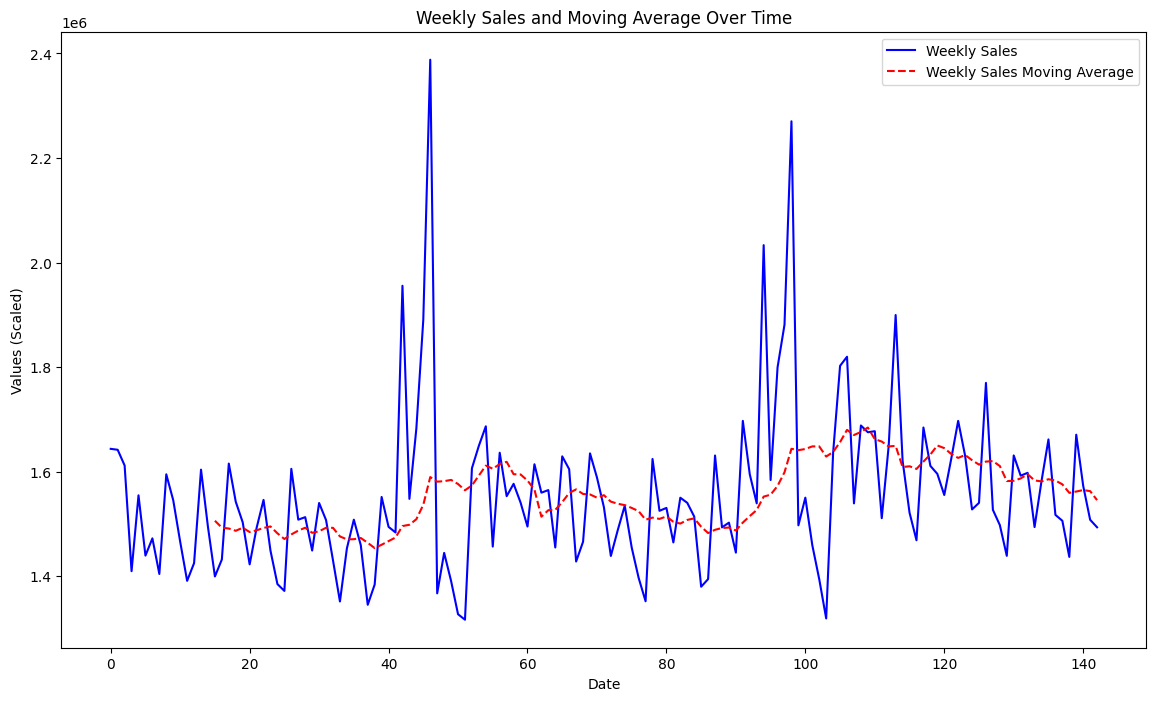

In [5]:
sales['Weekly_Sales_MA'] = sales['Weekly_Sales'].rolling(window=16).mean()

plt.figure(figsize=(14, 8))

plt.plot(sales.index, sales['Weekly_Sales'] * multipliers['Weekly_Sales'], label='Weekly Sales', color='blue')
plt.plot(sales.index, sales['Weekly_Sales_MA'] * multipliers['Weekly_Sales'], label='Weekly Sales Moving Average', color='red', linestyle='--')


plt.xlabel('Date')
plt.ylabel('Values (Scaled)')
plt.title('Weekly Sales and Moving Average Over Time')
plt.legend()

plt.show()

Média móvel das vendas identificada pela linha trastejada em vermelho, projetada sobre as vendas em azul.

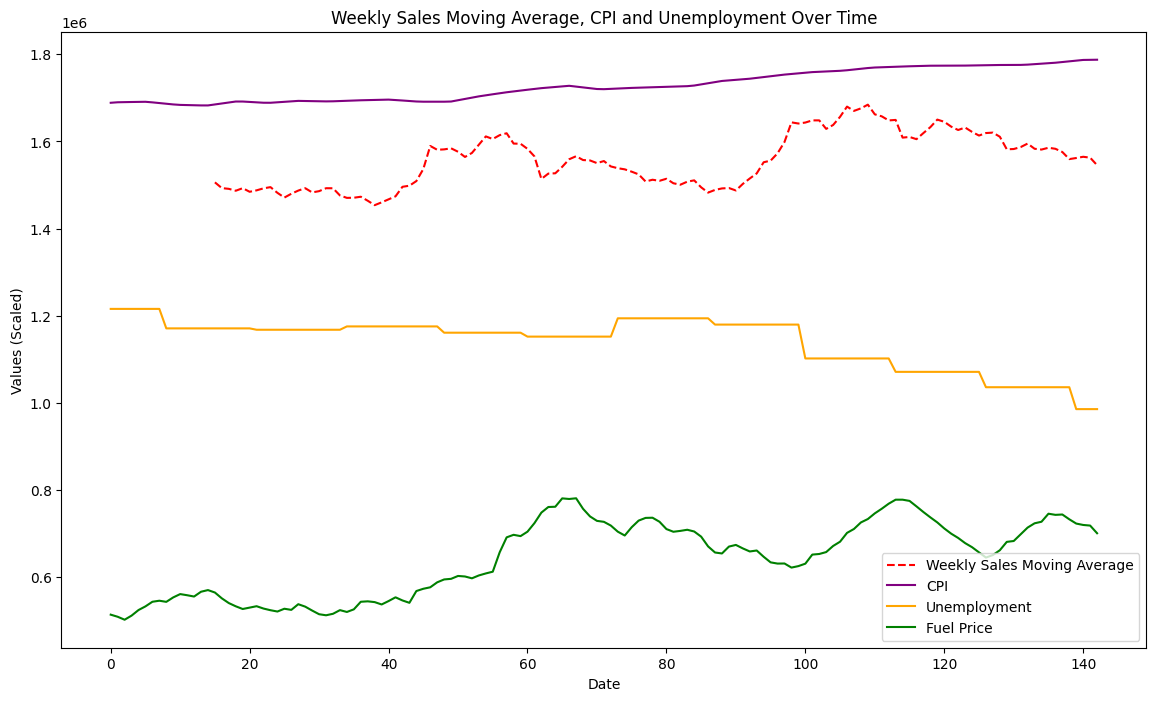

In [6]:
multipliers['Fuel_Price'] = 200000

plt.figure(figsize=(14, 8))

plt.plot(sales.index, sales['Weekly_Sales_MA'] * multipliers['Weekly_Sales'], label='Weekly Sales Moving Average', color='red', linestyle='--')
plt.plot(sales.index, sales['CPI'] * multipliers['CPI'], label='CPI', color='purple')
plt.plot(sales.index, sales['Unemployment'] * multipliers['Unemployment'], label='Unemployment', color='orange')
plt.plot(sales.index, sales['Fuel_Price'] * multipliers['Fuel_Price'], label='Fuel Price', color='green')

plt.xlabel('Date')
plt.ylabel('Values (Scaled)')
plt.title('Weekly Sales Moving Average, CPI and Unemployment Over Time')
plt.legend()

plt.show()

Média móvel substituindo às Vendas comparadas as demais colunas mais relevantes.

Porfim, conclui-se que aparentemente as vendas são afetadas positivamente pelo aumento do CPI e do Fuel_Price (preço de combustível), e negativamente pelo aumento de do desemprego. Nesta próxima etapa serão verificadas quais dessas correlações são mais ou menos fortes.

# Análise Diagnóstica

Propõe-se uma análise em que se compara as correlações entre as colunas auxiliares destacadas pela fase exploratória e a coluna principal, bem como sua média móvel.

In [7]:
pd.options.display.float_format = '{:.2f}'.format


correlation_fuel_original = sales['Weekly_Sales'].corr(sales['Fuel_Price'])
correlation_fuel_ma = sales['Weekly_Sales_MA'].corr(sales['Fuel_Price'])
correlation_cpi_original = sales['Weekly_Sales'].corr(sales['CPI'])
correlation_cpi_ma = sales['Weekly_Sales_MA'].corr(sales['CPI'])
correlation_unemployment_original = sales['Weekly_Sales'].corr(sales['Unemployment'])
correlation_unemployment_ma = sales['Weekly_Sales_MA'].corr(sales['Unemployment'])

correlation_data = {
    'Correlation_Type': ['Original', 'Moving_Average'],
    'Fuel_Price': [correlation_fuel_original, correlation_fuel_ma],
    'CPI': [correlation_cpi_original, correlation_cpi_ma],
    'Unemployment': [correlation_unemployment_original, correlation_unemployment_ma]
}

correlation_sales = pd.DataFrame(correlation_data)

print(correlation_sales)


  Correlation_Type  Fuel_Price  CPI  Unemployment
0         Original        0.12 0.23         -0.10
1   Moving_Average        0.54 0.68         -0.58


### Observação

Conforme esperado, têm-se uma correlação forte quando considerado a média móvel, calculada através do método Pearson, destacando-se CPI, Desemprego e Combustível, do que a coluna original. Tal informação sugere que algorítmos que se utilizam de cálculos de média móvel como parte do processo podem oferecer melhores respostas ao utilizar-se destas colunas auxiliares.

## Matriz de Correlação

Para completar a análise, segue-se a exposição da matriz de correlação abaixo.

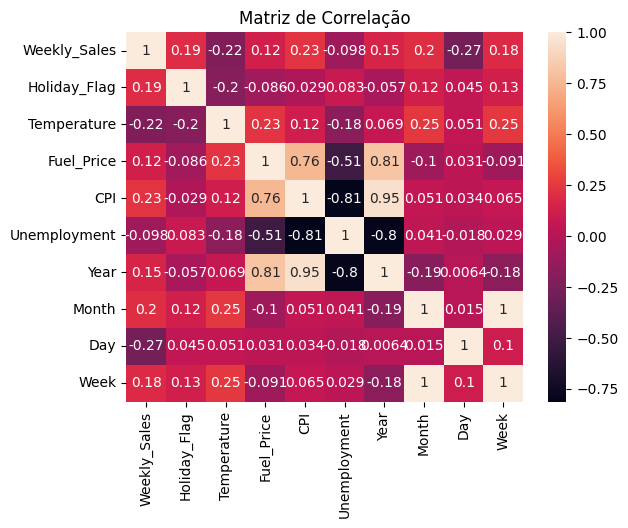

In [8]:
# Variévies derivadas da Date
sales['Date'] = pd.to_datetime(sales['Date'], format='%d-%m-%Y')
sales['Year'] = sales['Date'].dt.year
sales['Month'] = sales['Date'].dt.month
sales['Day'] = sales['Date'].dt.day
sales['Week'] = sales['Date'].dt.isocalendar().week
cols = ['Weekly_Sales','Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment','Year','Month','Day', 'Week']

# Gerando correlação
corr_matrix = sales[cols].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Matriz de Correlação')
plt.show()

# Análise Preditiva

## 1 - Modelo de Regressão Linear

In [9]:
# Libs para regressão Linear

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Defininindo (Y) e  (X)
X = sales[['Holiday_Flag','Temperature','Fuel_Price','CPI','Year','Month','Day', 'Week']]
Y = sales['Weekly_Sales']

# Split de 50% para cada
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Regressão Linear
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# Previsões nos dados de teste
Y_predicted = regressor.predict(X_test)

# Métricas do modelo
r2 = r2_score(Y_test, Y_predicted)
mse = mean_squared_error(Y_test, Y_predicted)
mae = mean_absolute_error(Y_test, Y_predicted)
rmse = np.sqrt(mse)

# Print resultados
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


# Coeficientes e importância de cada variável
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': regressor.coef_})
print("\nCoeficientes do modelo:")
print(coefficients.sort_values(by='Coefficient', ascending=False))


R-squared: 0.2375
Mean Squared Error: 19823615242.5897
Mean Absolute Error: 86360.0973
Root Mean Squared Error: 140796.3609

Coeficientes do modelo:
        Feature  Coefficient
7          Week   2411879.25
3           CPI     68540.83
2    Fuel_Price     51990.97
0  Holiday_Flag      5021.60
1   Temperature    -35086.19
4          Year   -107527.62
6           Day   -256708.42
5         Month  -2394020.28


### Conclusão

Com um RMSE próximo de 10% da ordem de grandeza média dos valores presentes na coluna principal e R2 de 0.2375, a regressão linear configura uma boa referência como um primeiro modelo.

## 2 - Modelo XGboost

In [10]:
# Lib XGB
from xgboost import XGBRegressor

# Defininindo (Y) e  (X)
X = sales[['Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment','Year','Month','Day', 'Week']]
Y = sales['Weekly_Sales']

# Split de 50% para cada
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# XGBoost e ajustar os hiperparâmetros
xgb_regressor = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_regressor.fit(X_train, Y_train)

# Previsões nos dados de teste
Y_predicted_xgb = xgb_regressor.predict(X_test)

# Métricas do modelo
r2_xgb = r2_score(Y_test, Y_predicted_xgb)
mse_xgb = mean_squared_error(Y_test, Y_predicted_xgb)
mae_xgb = mean_absolute_error(Y_test, Y_predicted_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Print resultados
print(f"XGBoost R-squared: {r2_xgb:.4f}")
print(f"XGBoost Mean Squared Error: {mse_xgb:.4f}")
print(f"XGBoost Mean Absolute Error: {mae_xgb:.4f}")
print(f"XGBoost Root Mean Squared Error: {rmse_xgb:.4f}")

# Print importância das variáveis
importances = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_regressor.feature_importances_})
print("\nImportância das variáveis:")
print(importances.sort_values(by='Importance', ascending=False))


XGBoost R-squared: 0.2475
XGBoost Mean Squared Error: 19563243658.3836
XGBoost Mean Absolute Error: 83327.3703
XGBoost Root Mean Squared Error: 139868.6657

Importância das variáveis:
        Feature  Importance
8          Week        0.37
0  Holiday_Flag        0.29
7           Day        0.13
3           CPI        0.08
6         Month        0.07
4  Unemployment        0.04
2    Fuel_Price        0.02
1   Temperature        0.00
5          Year        0.00


### Conclusão

Com métricas ligeiramente superiores ao modelo de regressão linear, o XGBoost fornece um algorítmo que entrega uma melhor alternativa.

## 3 - Modelo Híbrido (Prophet e XGBoost) - Overfiting

/home/lowe/Documents/fiap/final/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
23:50:49 - cmdstanpy - INFO - Chain [1] start processing
23:50:49 - cmdstanpy - INFO - Chain [1] done processing


Hybrid Model R-squared: 0.9999
Hybrid Model Mean Squared Error: 3019210.5030
Hybrid Model Mean Absolute Error: 1303.7614


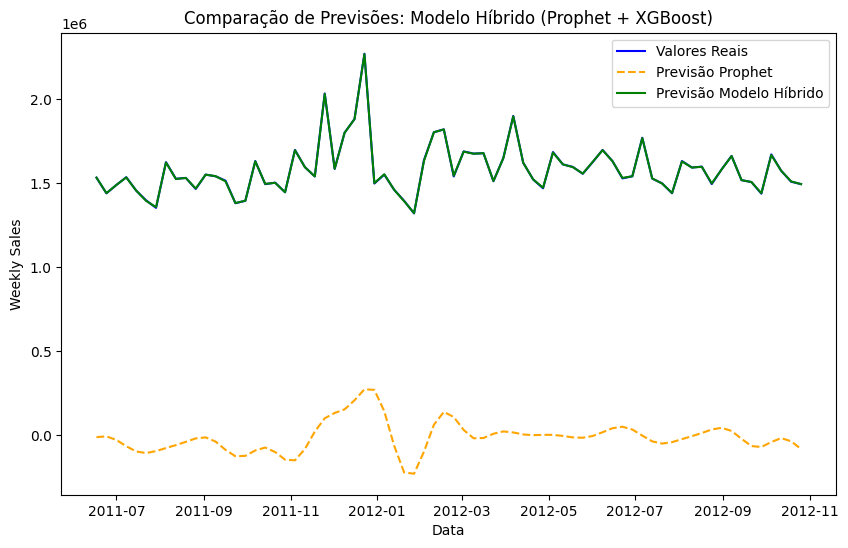

In [11]:
# Lib Prophet
from prophet import Prophet


# Variaveis no formato exigido pelo Prophet
sales_data = sales[['Date', 'Weekly_Sales']]
sales_data.columns = ['ds', 'y']

# Split de 50% para cada
train_size = int(len(sales_data) * 0.5)
train_data = sales_data[:train_size]
test_data = sales_data[train_size:]

# Prophet
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.add_country_holidays(country_name='US')
model_prophet.fit(train_data)

# Previsões nos dados de teste
future = model_prophet.make_future_dataframe(periods=len(test_data), freq='W')
forecast_prophet = model_prophet.predict(future)
forecast_test = forecast_prophet[-len(test_data):]  # Seleciona apenas previsões para o período de teste

# Remove o aviso SettingWithCopyWarning
test_data = test_data.copy()
# Residual das previsões e os valores reais
test_data['yhat_prophet'] = forecast_test['yhat'].values
test_data['residual'] = test_data['y'] - test_data['yhat_prophet']

# Variaveis para o XGBoost
X = sales[['Holiday_Flag', 'Fuel_Price', 'CPI', 'Year', 'Month', 'Week']][train_size:]
# Variável residual (Resultado Prophet)
Y_residual = test_data['residual']

# XGBoost e ajustar os hiperparâmetros
xgb_regressor = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_regressor.fit(X, Y_residual)

# Previsões nos dados de teste
residual_pred = xgb_regressor.predict(X)

# Previsões finais somando o valor previsto pelo Prophet e o ajuste de residual do XGBoost
y_pred_final = forecast_test['yhat'].values + residual_pred

# Metricas do modelo híbrido
y_true = test_data['y'].values
r2_hybrid = r2_score(y_true, y_pred_final)
mse_hybrid = mean_squared_error(y_true, y_pred_final)
mae_hybrid = mean_absolute_error(y_true, y_pred_final)

# Print resultados
print(f"Hybrid Model R-squared: {r2_hybrid:.4f}")
print(f"Hybrid Model Mean Squared Error: {mse_hybrid:.4f}")
print(f"Hybrid Model Mean Absolute Error: {mae_hybrid:.4f}")

# Print previsões do modelo híbrido em comparação com os valores reais
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], y_true, label='Valores Reais', color='blue')
plt.plot(test_data['ds'], forecast_test['yhat'].values, label='Previsão Prophet', color='orange', linestyle='--')
plt.plot(test_data['ds'], y_pred_final, label='Previsão Modelo Híbrido', color='green')
plt.legend()
plt.title("Comparação de Previsões: Modelo Híbrido (Prophet + XGBoost)")
plt.xlabel("Data")
plt.ylabel("Weekly Sales")
plt.show()

### Conclusão

Com R2 de 0.99, o modelo do Prophet apresentou overfiting, abrindo uma frente de possibilidades de ajuste.

## 4 - Modelo Híbrido (Prophet e XGBoost) - Ajuste hiperparâmetros.

23:50:51 - cmdstanpy - INFO - Chain [1] start processing
23:50:52 - cmdstanpy - INFO - Chain [1] done processing


Cross-validated MSE: 13821671684.4340
Hybrid Model R-squared: 0.9533
Hybrid Model Mean Squared Error: 1084134178.0732
Hybrid Model Mean Absolute Error: 25834.5334


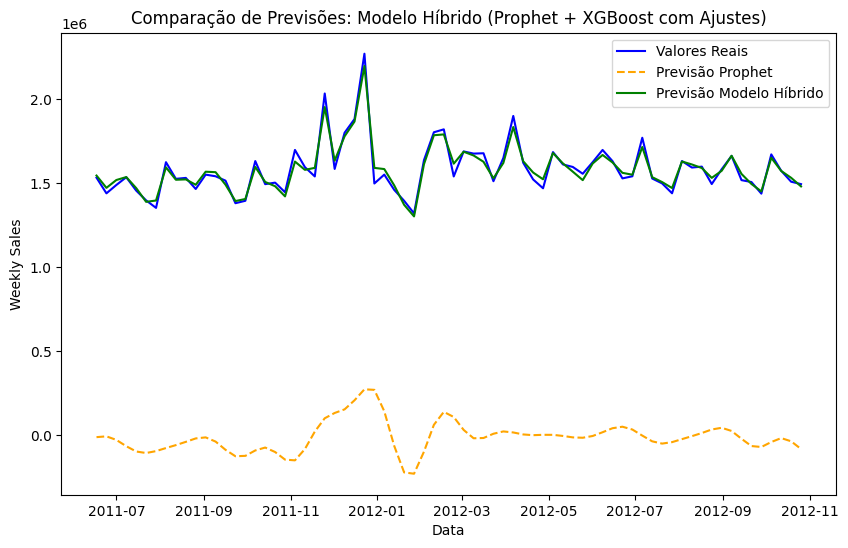

In [12]:
# Import bibliotecas
from sklearn.model_selection import cross_val_score

# Variaveis no formato exigido pelo Prophet
sales_data = sales[['Date', 'Weekly_Sales']]
sales_data.columns = ['ds', 'y']

# Split de 50% para cada
train_size = int(len(sales_data) * 0.5)
train_data = sales_data[:train_size]
test_data = sales_data[train_size:]

# Prophet
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.add_country_holidays(country_name='US')
model_prophet.fit(train_data)

# Previsões nos dados de teste
future = model_prophet.make_future_dataframe(periods=len(test_data), freq='W')
forecast_prophet = model_prophet.predict(future)
forecast_test = forecast_prophet[-len(test_data):]

# Remove o aviso SettingWithCopyWarning
test_data = test_data.copy()
# Residual das previsões e os valores reais
test_data['yhat_prophet'] = forecast_test['yhat'].values
test_data['residual'] = test_data['y'] - test_data['yhat_prophet']

# Variaveis para o XGBoost
X = sales[['Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment','Year','Month','Day', 'Week']][train_size:]
# Variável residual (Resultado Prophet)
Y_residual = test_data['residual']

# Ajuste dos parâmetros para reduzir o overfitting
xgb_regressor = XGBRegressor(
    n_estimators=50,         # Reduzindo o número de árvores
    max_depth=5,             # Diminuindo a profundidade máxima
    learning_rate=0.05,      # Taxa de aprendizado menor para ajustes mais suaves
    subsample=0.8,           # Amostra parcial para cada árvore
    colsample_bytree=0.8,    # Uso parcial das features
    reg_alpha=0.1,           # Regularização L1
    reg_lambda=0.1,          # Regularização L2
    random_state=42
)

# Validação cruzada para estimar o desempenho
cv_scores = cross_val_score(xgb_regressor, X, Y_residual, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE: {-cv_scores.mean():.4f}")

# XGBoost nos resíduos
xgb_regressor.fit(X, Y_residual)
residual_pred = xgb_regressor.predict(X)

# Previsões finais somando o valor previsto pelo Prophet e o ajuste de residual do XGBoost
y_pred_final = forecast_test['yhat'].values + residual_pred

# Metricas do modelo híbrido
y_true = test_data['y'].values
r2_hybrid = r2_score(y_true, y_pred_final)
mse_hybrid = mean_squared_error(y_true, y_pred_final)
mae_hybrid = mean_absolute_error(y_true, y_pred_final)

# Print resultados
print(f"Hybrid Model R-squared: {r2_hybrid:.4f}")
print(f"Hybrid Model Mean Squared Error: {mse_hybrid:.4f}")
print(f"Hybrid Model Mean Absolute Error: {mae_hybrid:.4f}")

# Print previsões do modelo híbrido em comparação com os valores reais
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], y_true, label='Valores Reais', color='blue')
plt.plot(test_data['ds'], forecast_test['yhat'].values, label='Previsão Prophet', color='orange', linestyle='--')
plt.plot(test_data['ds'], y_pred_final, label='Previsão Modelo Híbrido', color='green')
plt.legend()
plt.title("Comparação de Previsões: Modelo Híbrido (Prophet + XGBoost com Ajustes)")
plt.xlabel("Data")
plt.ylabel("Weekly Sales")
plt.show()

### Importância das Variáveis no Modelo XGBoost

        Feature  Importance
0  Holiday_Flag        0.21
8          Week        0.17
2    Fuel_Price        0.15
7           Day        0.15
6         Month        0.11
4  Unemployment        0.11
3           CPI        0.06
1   Temperature        0.04
5          Year        0.00


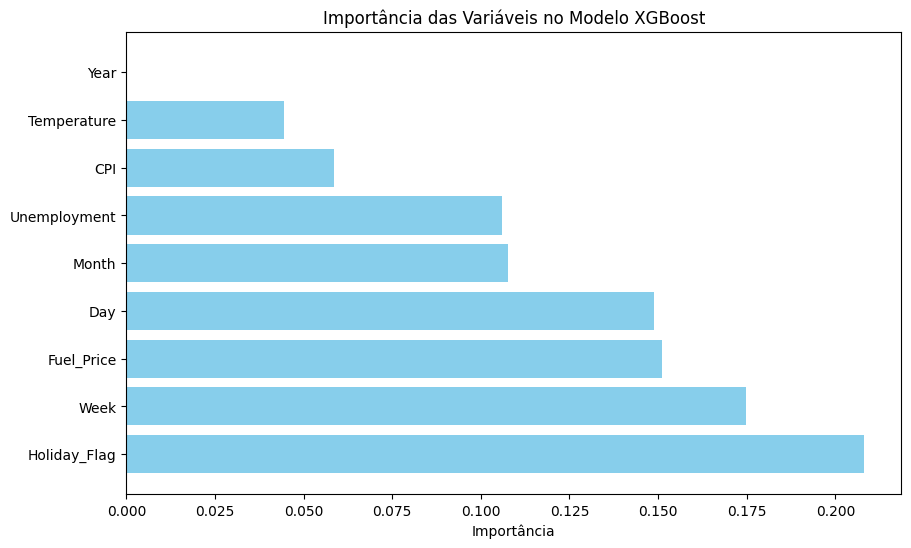

In [13]:
# Importâncias das variáveis
feature_importances = xgb_regressor.feature_importances_

# DataFrame para mostrar as importâncias
features = ['Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment','Year','Month','Day', 'Week']
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# variáveis ordenadas pela importância
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print as importâncias
print(importance_df)

# Print a importância das variáveis
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.title('Importância das Variáveis no Modelo XGBoost')
plt.show()


## 5 - Modelo Random Forest

In [14]:
# Ajusta o formato da data
sales['Date'] = pd.to_datetime(sales['Date'], format='%d-%m-%Y')
# sales.set_index('Date', inplace=True)

# Remove as colunas que não serão mais utilizadas
sales.drop('Holiday_Flag', axis=1, inplace=True)
sales.drop('Weekly_Sales_MA', axis=1, inplace=True)
sales.drop('Temperature', axis=1, inplace=True)


### Observação

As últimas análises a partir deste ponto não farão uso das colunas dos feriados e temperatura, apelando para meios de se encontrar sazonalidade a partir das próprias datas do ano, valendo-se das observações da análise exploratória.

In [15]:
from sklearn.ensemble import RandomForestRegressor


random_forest_df = sales.copy()

# Insere variáveis derivadas da data, para capturar sazonalidade segmentando por semana e ano
random_forest_df['WeekOfYear'] = random_forest_df['Date'].dt.isocalendar().week
random_forest_df['Year'] = random_forest_df['Date'].dt.year
random_forest_df['Weekly_Sales_Lag1'] = random_forest_df['Weekly_Sales'].shift(1)
random_forest_df = random_forest_df.dropna()

random_forest_df.head(10)

x = random_forest_df[['CPI', 'Unemployment', 'Fuel_Price', 'WeekOfYear', 'Year', 'Weekly_Sales_Lag1']]
y = random_forest_df['Weekly_Sales']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

random_forest_df.head(10)


,Date,Weekly_Sales,Fuel_Price,CPI,Unemployment,Year,Month,Day,Week,WeekOfYear,Weekly_Sales_Lag1
1,2010-02-12,1641957.44,2.55,211.24,8.11,2010,2,12,6,6,1643690.90
2,2010-02-19,1611968.17,2.51,211.29,8.11,2010,2,19,7,7,1641957.44
3,2010-02-26,1409727.59,2.56,211.32,8.11,2010,2,26,8,8,1611968.17
4,2010-03-05,1554806.68,2.62,211.35,8.11,2010,3,5,9,9,1409727.59
5,2010-03-12,1439541.59,2.67,211.38,8.11,2010,3,12,10,10,1554806.68
6,2010-03-19,1472515.79,2.72,211.22,8.11,2010,3,19,11,11,1439541.59
7,2010-03-26,1404429.92,2.73,211.02,8.11,2010,3,26,12,12,1472515.79
8,2010-04-02,1594968.28,2.72,210.82,7.81,2010,4,2,13,13,1404429.92
9,2010-04-09,1545418.53,2.77,210.62,7.81,2010,4,9,14,14,1594968.28
10,2010-04-16,1466058.28,2.81,210.49,7.81,2010,4,16,15,15,1545418.53


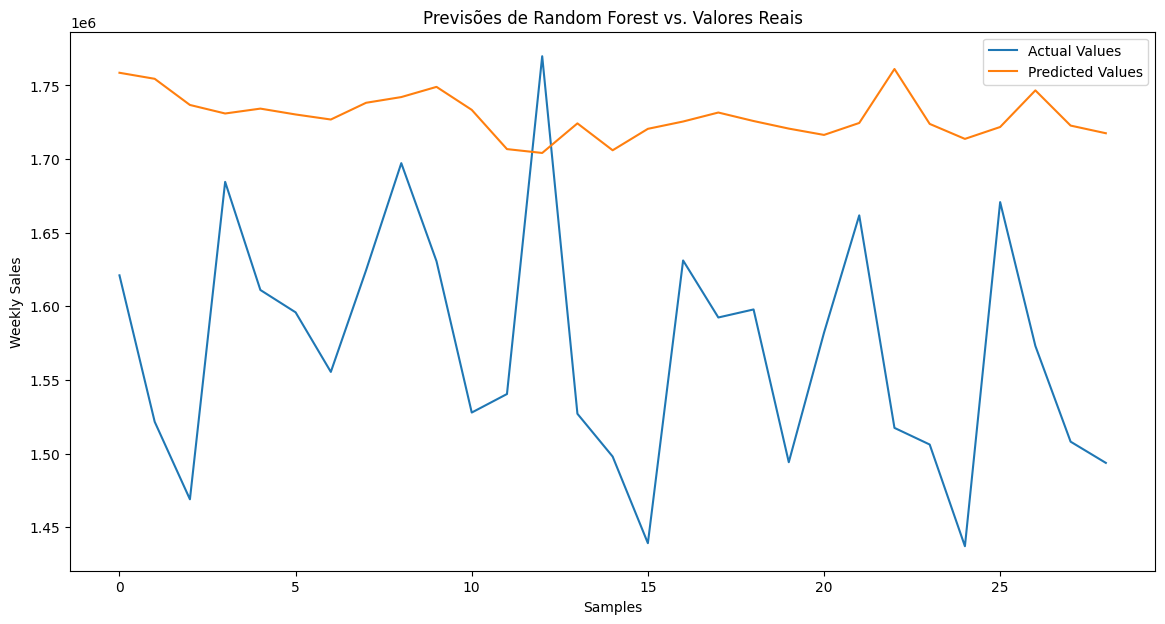

Random Forest RMSE: 176614.24703308326
Mean Squared Error: 31192592255.062958
R-squared: -3.914966348709413
Mean Absolute Error: 162125.98971379187


In [16]:
y_pred_rf = rf_model.predict(x_test)

plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Values')
plt.plot(y_pred_rf, label='Predicted Values')
plt.legend()
plt.title('Previsões de Random Forest vs. Valores Reais')
plt.xlabel('Samples')
plt.ylabel('Weekly Sales')
plt.show()

rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)

print(f'Random Forest RMSE: {rf_rmse}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Error: {mae}')

### Observação

Dadas estas métricas de erro bastante elevadas e R2 negativo, o Random Forest aplicado deste modo faz a pior performance entre os modelos preditivos.

## 6 - Modelo ARIMA Sazonal

O método do ARIMA inicia-se pela análise da estacionaridade da série, depois a definićão de seus parâmetros p, q e d.

Estatística ADF: -5.102186145192288
p-value: 1.3877788330759434e-05
A série é estacionária? -- Sim.


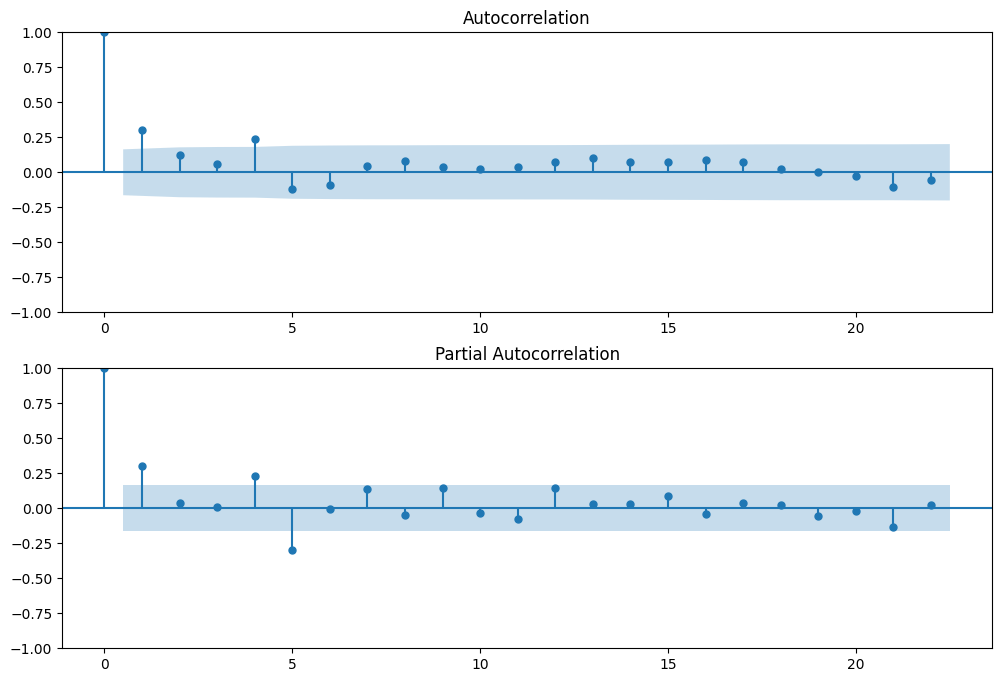

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


df = sales.reset_index()
df.set_index('Date', inplace=True)
df = df.asfreq('W-FRI')

y = df['Weekly_Sales']

adf_result = adfuller(y)
print(f'Estatística ADF: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

print(f'A série é estacionária? -- {"Sim." if adf_result[1] < 0.05 else "Não."}')

if adf_result[1] > 0.05:
    # Procedimento de diferenciação, que seria adotado para tornar a série estacionária
    y_diff = y.diff().dropna()
    adf_result_diff = adfuller(y_diff)
    print(f'ADF Statistic (Differenced): {adf_result_diff[0]}')
    print(f'p-value (Differenced): {adf_result_diff[1]}')
else:
    y_diff = y

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(y_diff, ax=ax[0])
plot_pacf(y_diff, ax=ax[1])
plt.show()


De acordo com os gráficos PACF e ACF e o p-value calculado, os valores 'p', 'd' e 'q' são respectivamente 5, 0 e 4.

In [18]:
y = df['Weekly_Sales']

train_size = int(len(df) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]

d = 0 # porque a série é estacionária desde o início
p = 5 # número de lags significativos no PACF
q = 4 # número de lags significativos no ACF

# Ajusta o modelo SARIMA. O valor 52 representa a quantidade de semanas em um ano, definindo a sazonalidade anual.
arima_model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(p, d, q, 52)).fit(disp=False)

arima_model.summary()

/home/lowe/Documents/fiap/final/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/lowe/Documents/fiap/final/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lowe/Documents/fiap/final/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/lowe/Documents/fiap/final/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(5, 0, 4)x(5, 0, 4, 52)   Log Likelihood               -1509.426
Date:                            Thu, 07 Nov 2024   AIC                           3056.851
Time:                                    23:58:42   BIC                           3108.839
Sample:                                02-05-2010   HQIC                          3077.950
                                     - 04-06-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7407      2.223     -0.333      0.739      -5.098       3.616
ar.L2          0.5217      0.815      0.640      0.522      -1.076       2.119
ar.L3          0.8364      0.927      0.902      0.367      -0.981       2.654
ar.L4          0.4176      0.825      0.506      0.613      -1.199       2.034
ar.L5         -0.0363      0.575     -0.063      0.950      -1.163       1.090
ma.L1          1.1680      2.396      0.488      0.626      -3.528       5.864
ma.L2         -0.0369      1.079     -0.034      0.973      -2.152       2.078
ma.L3         -1.0163      1.038     -0.979      0.327      -3.051       1.018
ma.L4         -0.6635      1.447     -0.459      0.646      -3.499       2.172
ar.S.L52       0.2611   4045.079   6.45e-05      1.000   -7927.948    7928.470
ar.S.L104      0.0467   1767.156   2.64e-05      1.000   -3463.515    3463.608
ar.S.L156      0.0505   1993.430   2.53e-05      1.000   -3907.001    3907.102
ar.S.L208      0.0598    761.803   7.85e-05      1.000   -1493.047    1493.167
ar.S.L260     -0.0218    946.813   -2.3e-05      1.000   -1855.742    1855.699
ma.S.L52       0.3016   4044.031   7.46e-05      1.000   -7925.854    7926.457
ma.S.L104      0.1340   1437.284   9.33e-05      1.000   -2816.890    2817.158
ma.S.L156      0.0290    822.009   3.52e-05      1.000   -1611.079    1611.137
ma.S.L208     -0.0414   1256.184  -3.29e-05      1.000   -2462.116    2462.033
sigma2      2.554e+10      0.001   2.33e+13      0.000    2.55e+10    2.55e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               121.57
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                             1.19
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.93e+29. Standard errors may be unstable.
"""

Uma vez treinado, dadas as especificações, podemos conferir os gráficos ACF e PACF do modelo.

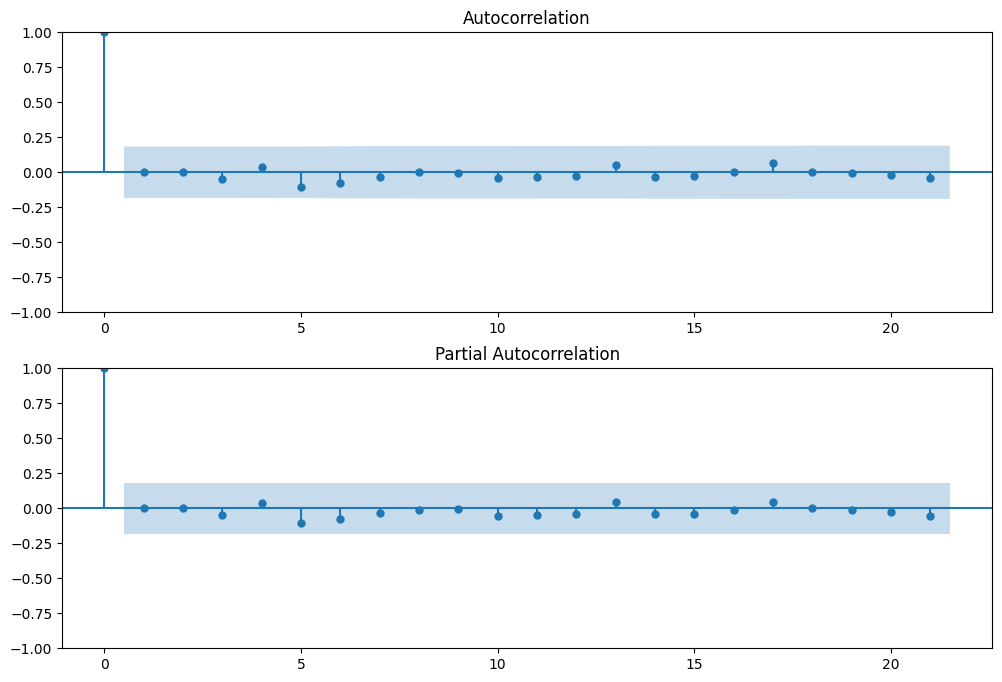

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(arima_model.resid, ax=ax[0])
plot_pacf(arima_model.resid, ax=ax[1])
plt.show()

A ausência pontos de 'lag' fora da área pintada nesta etapa indica que o modelo não precisa de mais treinos.

Mean Absolute Error (MAE): 62955.875658003846
Mean Squared Error (MSE): 5189135262.491978
Root Mean Squared Error (RMSE): 72035.6527178867
R-squared: 0.18235634327859473


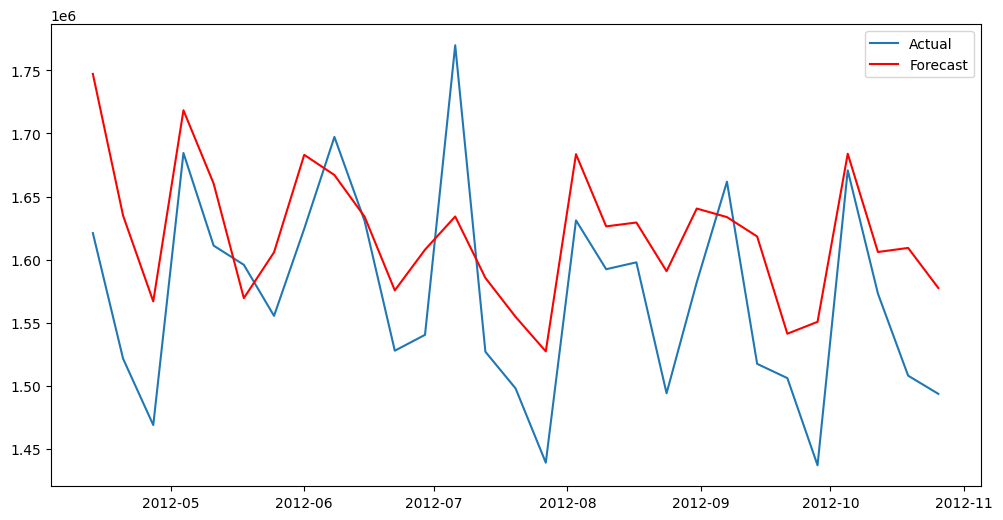

In [20]:
forecast = arima_model.forecast(steps=len(y_test))

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast)


print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared: {r2}')

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

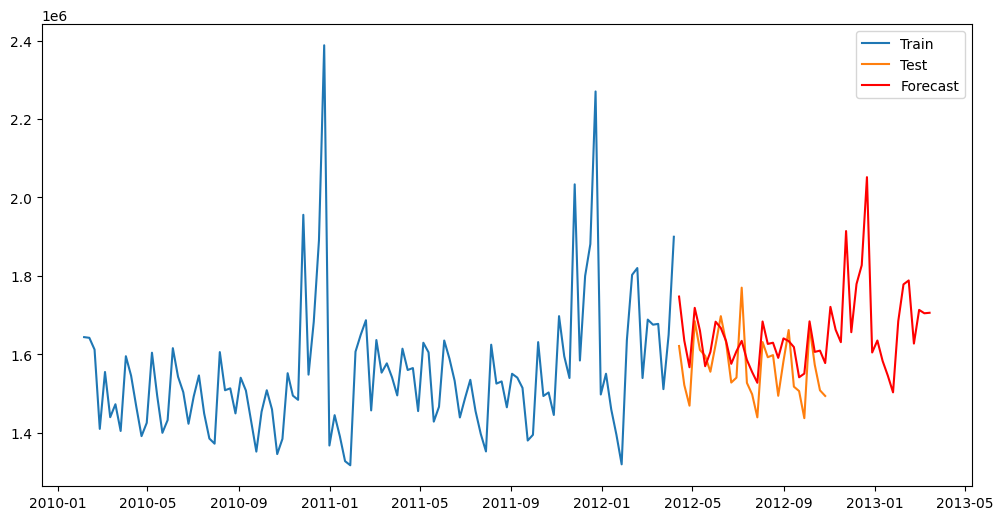

In [21]:
additional_steps = 20
total_steps = len(y_test) + additional_steps
extended_forecast = arima_model.forecast(steps=total_steps)

extended_forecast_df = extended_forecast.to_frame(name='Weekly_Sales_Forecast')
extended_forecast_df.index = pd.date_range(start=y_train.index[-1] + pd.Timedelta(weeks=1), periods=total_steps, freq='W-FRI')
extended_forecast_df.index.name = 'Date'

y_test_df = y_test.to_frame(name='Weekly_Sales_Test')
y_test_df.index = pd.date_range(start=y_train.index[-1] + pd.Timedelta(weeks=1), periods=len(y_test), freq='W-FRI')
y_test_df.index.name = 'Date'

y_train_df = y_train.to_frame(name='Weekly_Sales_Train')
y_train_df.index = pd.date_range(start=df.index[0], periods=len(y_train), freq='W-FRI')
y_train_df.index.name = 'Date'

combined_df = pd.concat([y_train_df, y_test_df, extended_forecast_df], axis=1)

plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Weekly_Sales_Train'], label='Train')
plt.plot(combined_df.index, combined_df['Weekly_Sales_Test'], label='Test')
plt.plot(combined_df.index, combined_df['Weekly_Sales_Forecast'], label='Forecast', color='red')
plt.legend()
plt.show()

### Observações

As métricas de erro são inferiores aos primeiros modelos, de Regressão Linear e XGboost, mas o R2 é inferior a ambos.

Entretanto, quando prolongada a projeção podemos observar que a sazonalidade parece bem representada, refletindo o padrão de oscilção esperado para o fim do ano.

Este é o único modelo em que é possível obter resultados utilizando apenas a coluna principal e as datas no eixo do tempo, uma vez indexadas no DataFrame, demonstrando o poder do algorítmo quando aplicado a este caso de uso.

O tempo de treino deste modelo é muito superior a todos os outros, o que pode ser uma grande desvantagem.

## 6.1 - Aperfeiçoamento do Modelo ARIMA Sazonal com Uma Coluna Exógena

É escolhida a coluna que anteriormente foi observada maior correlação com a média móvel extraída da coluna principal, a CPI, para testar a construção e treino de um novo modelo ARIMA Sazonal, com o intuito de conferir se é possível aprimorar os resultados com base neste algorítmo. 

In [22]:
x = df[['CPI']]

x_train, x_test = x[:train_size], x[train_size:]


exog_arima_model = SARIMAX(
    y_train, 
    order=(p, d, q), 
    seasonal_order=(p, d, q, 52),
    exog=x_train
    ).fit(disp=False)

exog_arima_model.summary()

/home/lowe/Documents/fiap/final/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(5, 0, 4)x(5, 0, 4, 52)   Log Likelihood               -1499.836
Date:                            Fri, 08 Nov 2024   AIC                           3039.671
Time:                                    00:24:57   BIC                           3094.395
Sample:                                02-05-2010   HQIC                          3061.880
                                     - 04-06-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI         7235.3469    358.999     20.154      0.000    6531.722    7938.972
ar.L1         -0.2439      1.575     -0.155      0.877      -3.330       2.842
ar.L2         -0.5578      1.208     -0.462      0.644      -2.925       1.810
ar.L3         -0.1989      0.861     -0.231      0.817      -1.887       1.489
ar.L4         -0.1099      0.769     -0.143      0.886      -1.618       1.398
ar.L5         -0.0255      0.694     -0.037      0.971      -1.386       1.335
ma.L1          0.5844      1.545      0.378      0.705      -2.444       3.613
ma.L2          0.7870      1.585      0.497      0.619      -2.319       3.893
ma.L3          0.3906      1.339      0.292      0.771      -2.234       3.015
ma.L4          0.5314      0.780      0.681      0.496      -0.998       2.061
ar.S.L52       0.2684   1.05e+05   2.56e-06      1.000   -2.06e+05    2.06e+05
ar.S.L104      0.2914   1.19e+05   2.46e-06      1.000   -2.32e+05    2.32e+05
ar.S.L156     -0.0517   5.38e+04  -9.62e-07      1.000   -1.05e+05    1.05e+05
ar.S.L208      0.0135   5.38e+04   2.52e-07      1.000   -1.05e+05    1.05e+05
ar.S.L260     -0.0120   4.66e+04  -2.58e-07      1.000   -9.14e+04    9.14e+04
ma.S.L52       0.2970   1.05e+05   2.84e-06      1.000   -2.05e+05    2.05e+05
ma.S.L104     -0.1160   1.94e+05  -5.99e-07      1.000    -3.8e+05     3.8e+05
ma.S.L156     -0.0116   9.27e+04  -1.26e-07      1.000   -1.82e+05    1.82e+05
ma.S.L208     -0.0212   7.12e+04  -2.97e-07      1.000    -1.4e+05     1.4e+05
sigma2       2.26e+10      0.008   2.75e+12      0.000    2.26e+10    2.26e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               150.22
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                             1.42
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.07e+32. Standard errors may be unstable.
"""

Uma vez treinado o modelo com uma coluna exógena, é necessário introduzir uma continuação para os dados desta coluna para testar o modelo. Para tal, o caminho adotado é recorrer a uma regressão linear nestes dados, uma vez que a coluna CPI expressa um gráfico linear bastante estável.

In [23]:
from sklearn.linear_model import LinearRegression


dates = np.arange(len(x)).reshape(-1, 1)

model = LinearRegression()
model.fit(dates, x)

future_dates = np.arange(len(x), len(x) + 20).reshape(-1, 1)
future_predictions = model.predict(future_dates)

future_index = pd.to_datetime([
    '2012-11-02', '2012-11-09', '2012-11-16', '2012-11-23', '2012-11-30',
    '2012-12-07', '2012-12-14', '2012-12-21', '2012-12-28', '2013-01-04',
    '2013-01-11', '2013-01-18', '2013-01-25', '2013-02-01', '2013-02-08',
    '2013-02-15', '2013-02-22', '2013-03-01', '2013-03-08', '2013-03-15'
])

extended_x = pd.concat([x, pd.DataFrame(future_predictions, columns=['CPI'], index=future_index)])
extended_x.index.name = 'Dates'

extended_x.tail(10)

,CPI
Dates,
2013-01-11,224.39
2013-01-18,224.49
2013-01-25,224.59
2013-02-01,224.69
2013-02-08,224.79
2013-02-15,224.90
2013-02-22,225.00
2013-03-01,225.10
2013-03-08,225.20


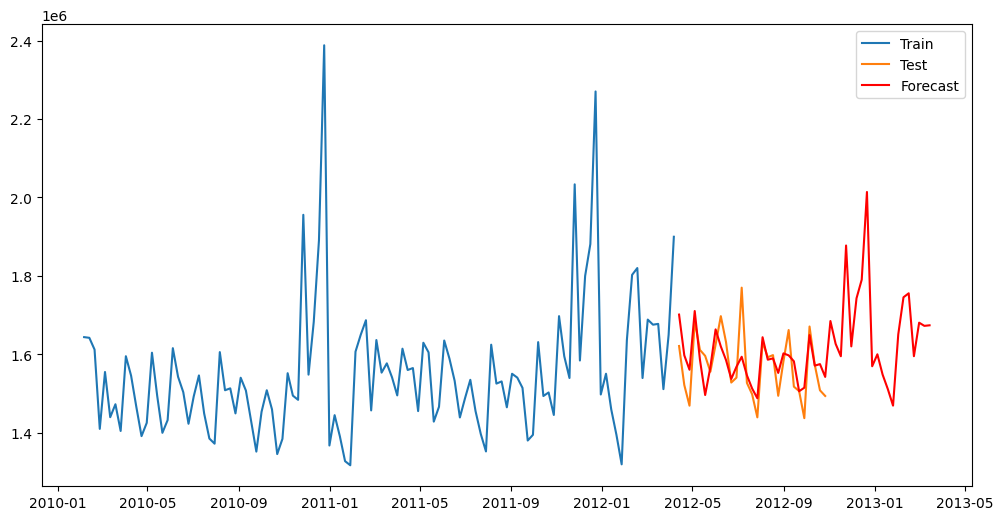

In [24]:
additional_steps = 20
total_steps = len(y_test) + additional_steps

exog_future = extended_x.tail(49)

extended_forecast = exog_arima_model.forecast(steps=total_steps, exog=exog_future)

extended_forecast_df = extended_forecast.to_frame(name='Weekly_Sales_Forecast')
extended_forecast_df.index = pd.date_range(start=y_train.index[-1] + pd.Timedelta(weeks=1), periods=total_steps, freq='W-FRI')
extended_forecast_df.index.name = 'Date'

y_test_df = y_test.to_frame(name='Weekly_Sales_Test')
y_test_df.index = pd.date_range(start=y_train.index[-1] + pd.Timedelta(weeks=1), periods=len(y_test), freq='W-FRI')
y_test_df.index.name = 'Date'

y_train_df = y_train.to_frame(name='Weekly_Sales_Train')
y_train_df.index = pd.date_range(start=df.index[0], periods=len(y_train), freq='W-FRI')
y_train_df.index.name = 'Date'

combined_df = pd.concat([y_train_df, y_test_df, extended_forecast_df], axis=1)

plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Weekly_Sales_Train'], label='Train')
plt.plot(combined_df.index, combined_df['Weekly_Sales_Test'], label='Test')
plt.plot(combined_df.index, combined_df['Weekly_Sales_Forecast'], label='Forecast', color='red')
plt.legend()
plt.show()

A projeção extendida se manteve fiel ao padrão de oscilação esperado.

Mean Absolute Error (MAE): 45495.32142004887
Mean Squared Error (MSE): 3520636435.9307485
Root Mean Squared Error (RMSE): 59334.951217058806
R-squared (R2): 0.4452590067812898


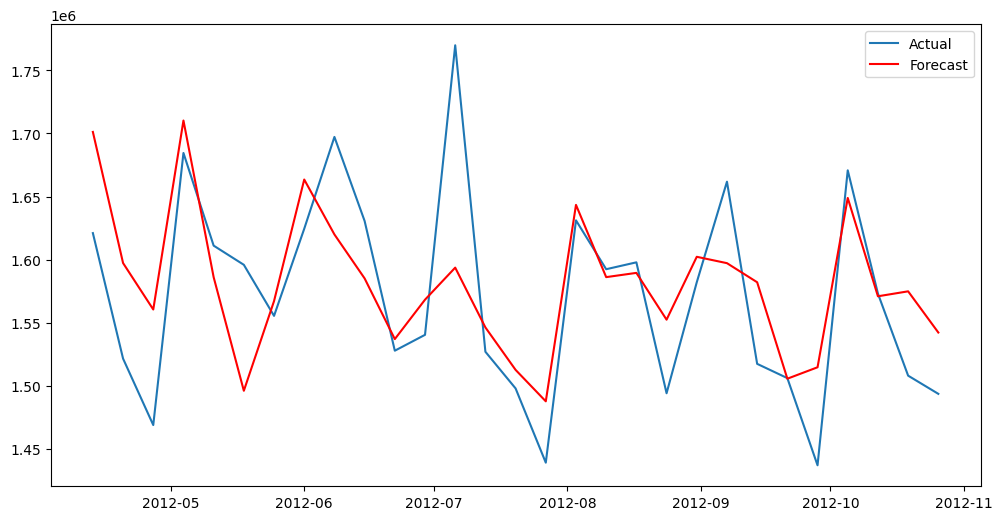

In [26]:
forecast = exog_arima_model.forecast(steps=len(y_test), exog=x_test)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

### Observações

As métricas de erro cairam um pouco e o R2 subiu para mais que o dobro do anterior, sem coluna exógena.

Este novo modelo é treinado em aproximadamente metade do tempo de sua versão anterior.

Tais informações podem indicar que a adição das demais colunas bem correlacionadas com a média móvel da coluna principal poderiam levar a resultados melhores e menor tempo de treino, além de abrir a possibilidade de parametrizar diferentes cenários de previsão, enviesando as projeções das colunas exógenas.